Model: "model"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_1 (InputLayer)               [(None, 20, 1)]                 0           
                                                                                
 conv1d (Conv1D)                    (None, 20, 30)                  150         
                                                                                
 max_pooling1d (MaxPooling1D)       (None, 18, 30)                  0           
                                                                                
 flatten (Flatten)                  (None, 540)                     0           
                                                                                
 dense (Dense)                      (None, 1)                       541         
                                                                                
Total params:

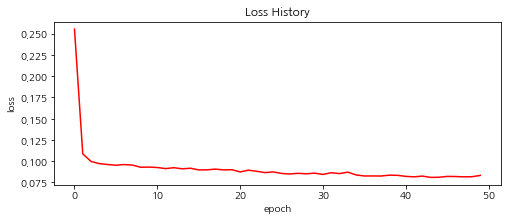

C:\Users\배진우\AppData\Local\Temp/ipykernel_16636/4291850956.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(ax1, past_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
C:\Users\배진우\AppData\Local\Temp/ipykernel_16636/4291850956.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(ax2, future_data, 'b-o', color='red', markersize=3, label='Estimatedk')


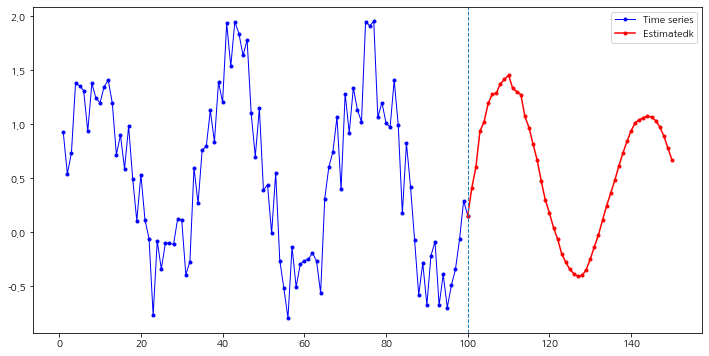

In [6]:
# CNN 예시 : 1D convolution을 이용하여 noisy sine 시계열을 예측한다.
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2차원 배열의 feature 데이터로 CNN 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = [data[i:(i+t_step), :] for i in m]      # feature data
    y = [data[i, :] for i in (m + t_step)]      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = np.reshape(np.array(x), (len(m), t_step, n_feat))
    y_target = np.reshape(np.array(y), (len(m), n_feat))
    
    return x_data, y_target

# 시계열 데이터 (noisy sin)
n_data = 1000
sine = np.sin(2 * np.pi * 0.03 * np.arange(n_data)) + np.random.random(n_data) # noisy sine

# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
# 미래의 sine 값을 target으로 만들어 주고, CNN을 학습한다.
df = pd.DataFrame({'sine':sine})
df.head()

t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape

# Convolutional 1D 모델을 생성한다.
n_feat = 1
x_input = Input(batch_shape = (None, t_step, n_feat))
x_conv = Conv1D(filters=30, kernel_size=4, strides=1, padding = 'same', activation='relu')(x_input)
x_pool = MaxPooling1D(pool_size=3, strides=1, padding='valid')(x_conv)
x_flat = Flatten()(x_pool)
y_output = Dense(1)(x_flat)

model = Model(x_input, y_output)
model.compile(loss='mse', optimizer = optimizers.Adam(learning_rate=0.001))
model.summary(line_length=80)

# 모델을 학습한다.
h = model.fit(x_train, y_train, epochs = 50, batch_size = 32)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 50 기간까지 예측한다.
n_future = 50
n_last = 100
last_data = data[-n_last:]  # 원 데이터의 마지막 n_last개만 그려본다

for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = last_data[-t_step:, :].reshape(1, t_step, 1)

    # 다음 값을 예측한다.
    y_hat = model.predict(px)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    last_data = np.vstack([last_data, y_hat])

past_data = last_data[:-n_future, :]
future_data = last_data[-(n_future + 1):, :]

last_data.shape, past_data.shape, future_data.shape

# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(past_data) + 1)
ax2 = np.arange(len(past_data), len(past_data) + len(future_data))
plt.plot(ax1, past_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, future_data, 'b-o', color='red', markersize=3, label='Estimatedk')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()


In [ ]:
# LSTM으로 mnist 데이터를 분류한다.
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle


# 저장된 mnist 데이터를 읽어온다.
DATA_PATH = 'C:\\Users\\배진우\\Documents\\multiCampus_TA\\python_data'
with open(DATA_PATH + 'mnist.pkl', 'rb') as f:
        mnist = pickle.load(f)

# mnist['data'] 숫자의 범위를 변환한다 (표준화) : 0 ~ 255 --> 0 ~ 1.0
# target = ['1', '2',...] 문자로 돼있음. --> 숫자로 변환해야 함.
x_feat = np.array(mnist['data']).reshape(-1, 28, 28) / 255
y_target = np.array(mnist['target'].to_numpy().astype('int8')).reshape(-1,1)

# 학습 데이터와 시험 데이터를 생성한다.
x_train, x_test, y_train, y_test = train_test_split(x_feat, y_target, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# 그래프 모델을 생성한다
n_hNeuron = 50
n_class = len(set(mnist['target']))

n_feat = 28
n_row = 28

x_input = Input(batch_shape = (None, n_row, n_feat))
x_conv = Conv1D(filters=30, kernel_size=4, strides=1, padding = 'same', activation='relu')(x_input)
x_pool = MaxPooling1D(pool_size=3, strides=1, padding='valid')(x_conv)
x_flat = Flatten()(x_pool)
y_output = Dense(n_class, activation='softmax')(x_flat)


model = Model(x_input, y_output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

hist = model.fit(x_train, y_train, 
                 batch_size=1024, 
                 epochs=50, 
                 validation_data = (x_test, y_test))

# error가 감소하는 모습을 관찰한다.
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1).reshape(-1,1)
acc = (y_test == y_pred).mean()
print('정확도 ={:.4f}'.format(acc))

import pandas as pd
df = pd.DataFrame({'y_test': y_test.reshape(-1,), 'y_pred': y_pred.reshape(-1,)})
df.head(10)

# 잘못 분류한 이미지 몇개를 확인해 본다.
# 어떤 이미지를 잘 맞추지 못할까? 사람이라면 아래 이미지를 잘 맞출 수 있을까?
n_sample = 10
miss_cls = np.where(y_test != y_pred)[0]
miss_sam = np.random.choice(miss_cls, n_sample)

fig, ax = plt.subplots(1, n_sample, figsize=(14,4))
for i, miss in enumerate(miss_sam):
    x = x_test[miss] * 255  # 표준화 단계에서 255로 나누었으므로, 여기서는 곱해준다.
    ax[i].imshow(x)
    ax[i].axis('off')
    ax[i].set_title(str(y_test[miss]) + ' / ' + str(y_pred[miss]))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 28, 30)            3390      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 26, 30)           0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 780)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                7810      
                                                                 
Total params: 11,200
Trainable params: 11,200
Non-trainable params: 0
______________________________________________________